In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize']=(12,8)
sns.set(rc={'figure.figsize':(15,8)})
plt.style.use('seaborn') 
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 2019 실적데이터

<참고사항> 

1. 취급액 = 판매단가 X 주문량 (취소,반품제외) 
2. 판매가 0원(무형상품)은 추정 제외 
3. 매주 토요일 18:00~18:20은 정보방송시간으로 추정 제외 (당사사정에 따라 ±20 편성 변경 있음)
4. 편성 듀레이션은  10분~60분내외 임 
5. 2020.06월 편성표는 월 ~ 토 6:20 ~ 2:20(익일), 일요일은 6:20 ~ 2:00로 구성 (심야시간대 제외)      
   단, raw data의 19.01.01 ~ 19.10.31은 6:00 ~ 2:00로 운영하였음. 11.01부터 6:20 ~ 2:20 운영

In [3]:
sales = pd.read_csv("2019실적데이터.csv", encoding="utf-8")

In [4]:
sales.rename(columns = {'방송일시' : 'date', "노출(분)" : "onair", "마더코드" : "mothercode", 
                        "상품코드" : "productcode", "상품명" : "product", "상품군" : "group", 
                        "판매단가" : "price", " 취급액 " : "total"}, inplace = True)

In [6]:
sales.shape

(38309, 8)

In [7]:
# 상품군 '무형' 제외한 dataframe 
# '무형' 판매단가 '-'로 되어 있어서... : 예측할 필요 없음 !!! 

sales = sales.loc[sales["group"] != "무형"]

In [8]:
# 숫자로 바꿔주기 
sales['price'] = sales['price'].apply(lambda x: int(x.replace(',', '')))
sales['total'] = sales['total'].apply(lambda x: int(x.replace(',', '')))

< FAQ >

1. 2019년 실적데이터 에서 취급액 50,000원으로 판매단가가 취급액보다 더 큰 상품의 데이터 값의 의미?            

- 2019년 실적데이터에서 취급액이 50,000원인 데이터는 데이터 정제과정에서 발생된 오류값으로.           
  취급액이 50,000원에 해당되는 상품에 대한 취급액은 0원으로 변경(주문량 0인 값)           
  ※ 해당내용을 반영한 데이터는 추후 수정하여 업데이트 예정

 

2. 취급액 = 판매단가 X 주문량 에서 주문량이 소수점으로 나오는 이유는?

- 일반적으로 취급액의 수식을 적용하면 일반적으로 판매단가X주문량이 맞습니다.           
  실제 현업에서 실적을 집계할때 고객이 실제 주문한 금액을 합산해서 보고있기 때문에 수식을 적용한것과는 차이가 있을 수 있습니다.          
  고객이 상품을 구매할때 판매가를 그대로 지불하지 않고 **할인쿠폰 적용, ARS할인, 일시불할인, 카드사할인 등** 여러가지 경로로 할인된 금액을 지불하고 있습니다.        
  (단, 결제시 적립금, 상품권 등을 사용하여 실결제금액이 바뀌는 경우는 해당사항 없음)              
  이에 주문량이 소수점으로 발생할 수 있음을 참고하여 주시기 바랍니다.

In [9]:
sales.head()

,date,onair,mothercode,productcode,product,group,price,total
0,2019-01-01 6:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000
1,2019-01-01 6:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000
2,2019-01-01 6:20,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000
3,2019-01-01 6:20,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000
4,2019-01-01 6:40,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000


In [10]:
# 오류값 제거 : 3000개 정도 없어짐 
sales = sales.query("price <= total and total != 50000")
sales.shape

(35379, 8)

In [12]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 38303
Data columns (total 8 columns):
date           35379 non-null object
onair          20403 non-null float64
mothercode     35379 non-null int64
productcode    35379 non-null int64
product        35379 non-null object
group          35379 non-null object
price          35379 non-null int64
total          35379 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.4+ MB


In [11]:
# 방송시간의 경우 NaN 값은 앞의 값으로 채워주면 됨 ! 
# 방송시간 다 채워준 데이터는 따로 고려해보기 

sales2 = sales.copy()
sales2["onair"] = sales2["onair"].fillna(method='ffill')

In [13]:
sales2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35379 entries, 0 to 38303
Data columns (total 8 columns):
date           35379 non-null object
onair          35379 non-null float64
mothercode     35379 non-null int64
productcode    35379 non-null int64
product        35379 non-null object
group          35379 non-null object
price          35379 non-null int64
total          35379 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 2.4+ MB


# EDA

## 방송 편성표 
* 현재 ns홈쇼핑의 방송 편성표 데이터를 보고, 지금까지 어떤 식으로 방송 편성을 해왔는지 체크해 보기로 함 

### 방송 시간 (onair) 

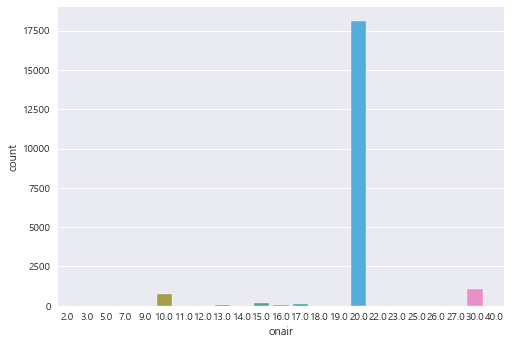

In [14]:
# 방송시간 분포 
sns.countplot(x = 'onair', data = sales)

In [16]:
sales['onair'].value_counts().sort_index()

2.0         1
3.0         6
5.0         5
7.0         6
9.0         1
10.0      754
11.0        4
12.0        2
13.0       49
14.0        2
15.0      189
16.0       72
17.0      116
18.0        3
19.0        3
20.0    18102
22.0        3
23.0        5
25.0        4
26.0        6
27.0        2
30.0     1067
40.0        1
Name: onair, dtype: int64

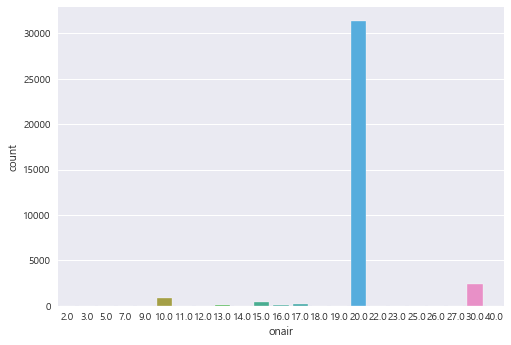

In [15]:
# ffill로 채웠을 때의 방송 편성 시간대 
sns.countplot(x = 'onair', data = sales2)

In [17]:
sales2['onair'].value_counts().sort_index()

2.0         1
3.0         9
5.0         5
7.0         6
9.0         1
10.0      805
11.0        4
12.0        5
13.0       67
14.0        2
15.0      435
16.0      115
17.0      160
18.0        4
19.0        3
20.0    31357
22.0        4
23.0        9
25.0        4
26.0       12
27.0        2
30.0     2367
40.0        2
Name: onair, dtype: int64

* 대부분 20분정도 편성되고 
* 31357 / 18102 = 1.73 이므로 하나의 방송에서 옵션 두개정도씩 파는듯 ? 

#### 이상치 체크 

In [20]:
# 1. 방송 duration에 맞지 않는 편성표 
sales.query('2.0 <= onair < 10')

,date,onair,mothercode,productcode,product,group,price,total
6690,2019-03-10 8:40,2.0,100452,201401,NNF 소프트 베스트 앙상블,의류,29900,10731000
9537,2019-04-05 14:40,3.0,100695,202058,남영비비안 소노르 베르사유 노와이어 컬렉션 브라,속옷,99000,8974000
14025,2019-05-13 1:50,3.0,100281,201009,에버라스트 드로즈 10+4종,속옷,39900,3945000
14977,2019-05-21 1:50,3.0,100634,201944,모리츠 에어 서큘레이터 1종,생활용품,49900,6376000
18532,2019-06-24 1:50,3.0,100634,201944,모리츠 에어 서큘레이터 1종,생활용품,49900,4907000
22692,2019-08-02 1:50,5.0,100213,200759,스포메틱스 트리플 샤이닝 쿠션시즌1,이미용,39900,8150000
23898,2019-08-13 1:50,5.0,100213,200759,스포메틱스 트리플 샤이닝 쿠션시즌1,이미용,39900,5360000
24372,2019-08-17 12:40,9.0,100348,201089,벨레즈온 브라캡 심리스 원피스 패키지,속옷,29900,971000
24779,2019-08-21 1:50,5.0,100213,200759,스포메틱스 트리플 샤이닝 쿠션시즌1,이미용,39900,4389000
25920,2019-09-02 1:50,5.0,100093,200254,[페플럼제이] 19Fall' 소프트 루즈 니트 풀오버 4종,의류,79000,2910000


* 방송 기본 편성 시간이 10분부터인데, 이 전의 값들은 무엇을 의미하는지 체크해야 할 것 같다 
* 너무 잘 팔려서 빨리 매진된걸까? (판매량이 100이 넘는 경우가 대부분) 

In [107]:
# 2. 10 / 15 / 20 / 30 이외의 숫자들 
sales2.query('onair == 40')

,date,onair,mothercode,productcode,product,group,price,total
34954,2019-11-29 2:00,40.0,100623,201926,콜라겐3.2 아임파인 (6개월),건강기능,89900,16770000
34955,2019-11-29 2:00,40.0,100623,201925,콜라겐3.2 아임파인 (3개월),건강기능,59900,3511000


* 방송 마지막타임에 방송한 상품인데, 방송시간도 엄청 길었고 + 어마어마하게 팔린 것을 볼 수 있음 

#### 방송시간 20분
* 일단 onair 숫자만 가지고 체크를 했는데, 
* 해당 방송이 다음 방송과의 시간 차이를 계산하고 (dropna 해서 NaN값 없는 행들과 비교해야 할듯) 
* onair 변수와 그 시간차이가 일치하는지, 일치하지 않는지로 비교해 봐야 할 것 같음 


* 그리고 방송 마지막타임에 편성되었는데 조기종료된 상품들은 ... 그냥 조금 빨리 방송을 끝내버린 것으로 생각됨 (그런 데이터가 너무 많음)  

In [112]:
# 방송시간이 20분인데 그 전에 조기종료된 상품들 (추측), 15분은 일단 제외 
sales2.query('11 <= onair < 15 or 16 <= onair < 20')

,date,onair,mothercode,productcode,product,group,price,total
66,2019-01-02 1:40,17.0,100193,200652,레이프릴 무빙 맥시풀커버 브라팬티,속옷,69900,18695000
170,2019-01-03 1:40,17.0,100613,201894,푸마 웜셀 기모 치마레깅스 3종,속옷,59000,24910000
265,2019-01-04 1:40,17.0,100229,200800,벨라홈 논슬립 옷걸이 세트,생활용품,29800,20974000
349,2019-01-05 1:40,17.0,100293,200952,일시불[가이거] 제니스시계 주얼리세트,잡화,129000,20633000
350,2019-01-05 1:40,17.0,100293,200949,무이자[가이거] 제니스시계 주얼리세트,잡화,139000,8495000
...,...,...,...,...,...,...,...,...
37866,2019-12-27 1:40,17.0,100312,201006,블랙모어스 알티지 오메가3 3병 (53주분),건강기능,95200,9804000
37948,2019-12-28 1:40,17.0,100841,202484,옛날 그 쥐포 110장 (11팩),농수축,32900,29330000
38051,2019-12-29 1:40,17.0,100723,202114,아이앤아이 퀵래쉬 속눈썹세트,이미용,59000,20588000
38136,2019-12-30 1:40,17.0,100226,201021,코이모 리빙박스 8종,생활용품,50800,18854000


In [113]:
# 우리가 분류한 상품명으로 비교하기 전 데이터 -> 추후 수정 필요
print("mothercode : ", sales2.query('11 <= onair < 15 or 16 <= onair < 20')["mothercode"].nunique())
print("product : ", sales2.query('11 <= onair < 15 or 16 <= onair < 20')["productcode"].nunique())  

mothercode :  143
product :  244


In [122]:
sales4 = sales2.copy()
sales4 = sales4.query('11 <= onair < 15 or 16 <= onair < 20')
sales4.shape

(360, 8)

In [123]:
# 할인율 고려하지 않은 판매량 -> 추후 수정 필요 
sales4["amount"] = sales4["total"] / sales4["price"]

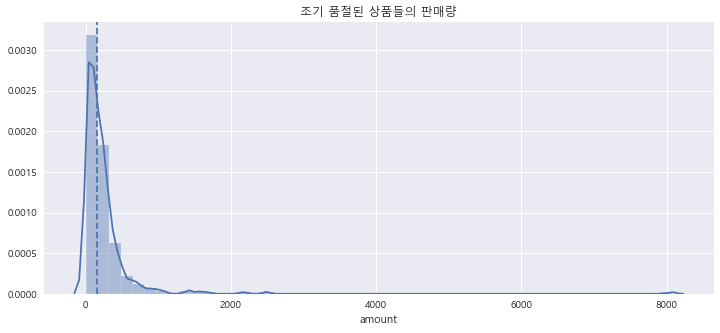

In [124]:
plt.subplots(figsize = (12,5))
sns.distplot(sales4["amount"])
plt.axvline(sales4["amount"].median(), linestyle = "dashed")
plt.title("조기 품절된 상품들의 판매량")
plt.show()

In [125]:
# 2000개 이상 팔린 제품들 
sales4.sort_values("amount", ascending=False).head(3)

,date,onair,mothercode,productcode,product,group,price,total,amount
35784,2019-12-07 1:40,17.0,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,322009000,8070.401003
37181,2019-12-19 18:00,18.0,100699,202064,고창 꿀 고구마 10kg,농수축,30900,76905000,2488.834951
33870,2019-11-17 17:00,13.0,100492,201486,피시원 국내산 절단 햇 꽃게 2.4kg,농수축,49900,108590000,2176.152305


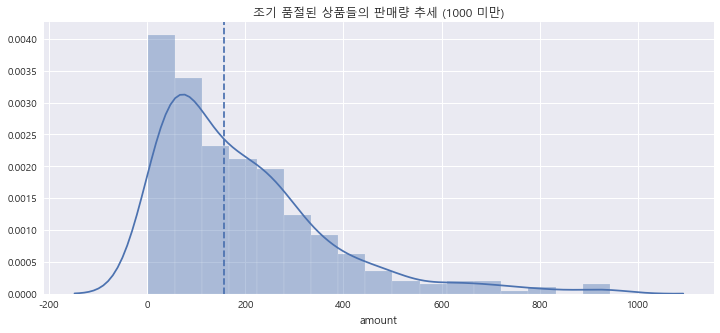

In [126]:
# 너무 지나치게 큰 값을 제외해 봄 !
sales4 = sales4.loc[sales4["amount"] < 1000]

plt.subplots(figsize = (12,5))
sns.distplot(sales4["amount"])
plt.axvline(sales4["amount"].median(), linestyle = "dashed")
plt.title("조기 품절된 상품들의 판매량 추세 (1000 미만)")
plt.show()

* 생각보다 몇 개 안 팔렸는데도 조기종료 되는 경우도 꽤 있는듯 ? (0 ~ 50 사이의 값이 제일 큰 것을 보면...) 

In [133]:
# 판매량 낮은 제품인데 조기종료된 경우 
sales4.sort_values("amount", ascending=True).head(10)

,date,onair,mothercode,productcode,product,group,price,total,amount
33414,2019-11-13 1:40,17.0,100076,200209,(일)이누스바스 시공패키지,가구,2682000,3503000,1.306115
33415,2019-11-13 1:40,17.0,100076,200208,(무)이누스바스 시공패키지,가구,2980000,5804000,1.947651
34575,2019-11-25 1:40,17.0,100421,201326,킹스스파 편백 반신욕기,생활용품,569000,1869000,3.284710
16674,2019-06-06 1:40,13.0,100182,200613,무이자 선일금고 이볼브 시리즈 EV-040,생활용품,490000,1701000,3.471429
16676,2019-06-06 1:40,13.0,100182,200612,무이자 선일금고 이볼브 시리즈 EV-020,생활용품,440000,1529000,3.475000
16675,2019-06-06 1:40,13.0,100182,200614,일시불 선일금고 이볼브 시리즈 EV-020,생활용품,400000,1391000,3.477500
14609,2019-05-18 1:40,13.0,100611,201893,푸마 여아 주니어 기능성 데일리 홈웨어세트,속옷,69000,282000,4.086957
4832,2019-02-20 1:40,16.0,100610,201863,푸마 INNO 심리스 롱드로즈 7종,속옷,89000,422000,4.741573
5968,2019-03-03 13:00,12.0,100577,201704,무이자 삼성 노트북 9 메탈 고급형 NT900X5J-K28,가전,1349000,7462000,5.531505
9128,2019-04-02 1:40,16.0,100182,200613,무이자 선일금고 이볼브 시리즈 EV-040,생활용품,490000,3399000,6.936735


In [183]:
sales.loc[33410:33415]

,date,onair,mothercode,productcode,product,group,price,total,방송일,방송시간(시),방송시간(분),방송요일
33410,2019-11-13 00:00:00,NaN,100594,201824,레스토닉 블루투스 LED 서랍 침대 킹,가구,749000,30443000,2019-11-13,0,0,2
33414,2019-11-13 01:40:00,17.0,100076,200209,(일)이누스바스 시공패키지,가구,2682000,3503000,2019-11-13,1,40,2
33415,2019-11-13 01:40:00,NaN,100076,200208,(무)이누스바스 시공패키지,가구,2980000,5804000,2019-11-13,1,40,2


In [182]:
sales.loc[4815:4833]

,date,onair,mothercode,productcode,product,group,price,total,방송일,방송시간(시),방송시간(분),방송요일
4815,2019-02-19 22:40:00,NaN,100148,200439,무이자 LG 울트라HD TV 65UK6800HNC,가전,2130000,32745000,2019-02-19,22,40,1
4816,2019-02-19 22:40:00,NaN,100148,200515,일시불 LG 울트라HD TV 70UK6800HNC,가전,2700000,6964000,2019-02-19,22,40,1
4817,2019-02-19 22:40:00,NaN,100148,200448,무이자 LG 울트라HD TV 70UK6800HNC,가전,2990000,7710000,2019-02-19,22,40,1
4818,2019-02-19 23:00:00,20.0,100742,202178,도스문도스 카이만 엠보 소가죽 핸드백 1종,잡화,99000,44757000,2019-02-19,23,0,1
4819,2019-02-19 23:20:00,20.0,100742,202178,도스문도스 카이만 엠보 소가죽 핸드백 1종,잡화,99000,46919000,2019-02-19,23,20,1
4820,2019-02-19 23:40:00,20.0,100742,202178,도스문도스 카이만 엠보 소가죽 핸드백 1종,잡화,99000,52202000,2019-02-19,23,40,1
4821,2019-02-20 00:00:00,20.0,100049,202046,마리노블 밍크 퍼 베스트,의류,269000,10422000,2019-02-20,0,0,2
4822,2019-02-20 00:20:00,20.0,100049,202046,마리노블 밍크 퍼 베스트,의류,269000,23198000,2019-02-20,0,20,2
4823,2019-02-20 00:40:00,20.0,100049,202046,마리노블 밍크 퍼 베스트,의류,269000,26350000,2019-02-20,0,40,2
4824,2019-02-20 01:00:00,20.0,100610,201886,푸마 심리스 드로즈 블랙에디션 패키지,속옷,89000,9339000,2019-02-20,1,0,2


* 비싼 제품인데 넘 안팔려서 빨리 끝냈나...? 
* 1:40에 방송한 데이터 말고 다른 데이터를 좀 봐야할 것 같음 

In [140]:
sales2['date'] = pd.to_datetime(sales2['date'])

In [141]:
sales2['방송시간(시)'] = sales2['date'].dt.hour
sales2['방송시간(분)'] = sales2['date'].dt.minute

In [142]:
sales2["amount"] = sales2["total"] / sales2["price"]

In [144]:
sales5 = sales2.query('11 <= onair < 15 or 16 <= onair < 20')

In [145]:
sales5[(sales5['방송시간(시)'] != 1) & (sales5['방송시간(분)'] != 40)]

,date,onair,mothercode,productcode,product,group,price,total,방송시간(시),방송시간(분),amount
5961,2019-03-03 12:20:00,12.0,100448,202097,일시불 쿠첸 풀스텐 압력밥솥 10인용,주방,158000,20502000,12,20,129.759494
5963,2019-03-03 12:20:00,12.0,100448,202099,일시불 쿠첸 풀스텐 압력밥솥 6인용(A1),주방,148000,7496000,12,20,50.648649
5964,2019-03-03 12:20:00,12.0,100448,202094,무이자 쿠첸 풀스텐 압력밥솥 6인용(A1),주방,158000,6280000,12,20,39.746835
5968,2019-03-03 13:00:00,12.0,100577,201704,무이자 삼성 노트북 9 메탈 고급형 NT900X5J-K28,가전,1349000,7462000,13,0,5.531505
33097,2019-11-09 17:00:00,13.0,100548,201634,완도꼬마활전복 1.3kg,농수축,29900,46607000,17,0,1558.762542
33870,2019-11-17 17:00:00,13.0,100492,201486,피시원 국내산 절단 햇 꽃게 2.4kg,농수축,49900,108590000,17,0,2176.152305
35668,2019-12-05 21:00:00,11.0,100317,201004,국내산 손질 햇 갑오징어 9팩,농수축,49900,47069000,21,0,943.266533
36634,2019-12-14 17:20:00,11.0,100548,201634,완도꼬마활전복 1.3kg,농수축,29900,41972000,17,20,1403.745819
37181,2019-12-19 18:00:00,18.0,100699,202064,고창 꿀 고구마 10kg,농수축,30900,76905000,18,0,2488.834951


* 꿀고구마 댑악..... + 꽃게 전복 갑오징어 뭔데 ... 
* 노트북은 왜 5개밖에 안 팔렸는데 방송시간은 12분 이었을까 ..? 

#### 방송시간 30분 

In [127]:
sales2.query('21 <= onair < 30')

,date,onair,mothercode,productcode,product,group,price,total
1485,2019-01-17 1:30,27.0,100215,200761,세인트스코트 얼티밋 캐리어 7종 세트(백팩),잡화,129000,29034000
1975,2019-01-22 1:30,26.0,100215,200761,세인트스코트 얼티밋 캐리어 7종 세트(백팩),잡화,129000,23172000
5047,2019-02-22 1:30,26.0,100215,200761,세인트스코트 얼티밋 캐리어 7종 세트(백팩),잡화,129000,21288000
5930,2019-03-03 1:30,26.0,100737,202164,무이자 김병만의 달인 공구 세트,생활용품,178000,9861000
5931,2019-03-03 1:30,26.0,100737,202167,일시불 김병만의 달인 공구 세트,생활용품,173000,10914000
7824,2019-03-21 1:30,26.0,100209,200747,무이자 모즈 커피머신&미니오븐,주방,188000,9028000
7825,2019-03-21 1:30,26.0,100209,200752,일시불 모즈 커피머신&미니오븐,주방,168000,9008000
7826,2019-03-21 1:30,26.0,100209,200746,무이자 모즈 커피머신,주방,129000,1497000
7827,2019-03-21 1:30,26.0,100209,200751,일시불 모즈 커피머신,주방,119000,1049000
7828,2019-03-21 1:30,26.0,100209,200745,무이자 모즈 미니오븐,주방,89000,2039000


In [129]:
sales2.iloc[10002] # 판매량 대략 254.329

date                       2019-04-14 23:40
onair                                    20
mothercode                           100374
productcode                          201198
product        19 SS USPA  남성 화이트라벨 폴로셔츠 3종
group                                    의류
price                                 79000
total                              20092000
Name: 10668, dtype: object

In [130]:
sales2.iloc[8880] # 판매량 대략 252.487

date           2019-04-04 13:40
onair                        20
mothercode               100731
productcode              202145
product          월드컵 여성19SS트레킹화
group                        잡화
price                     39800
total                  10049000
Name: 9403, dtype: object

In [131]:
sales2.query('31 <= onair < 40')

,date,onair,mothercode,productcode,product,group,price,total


< 결론 > 
* 대부분 방송시간은 20분으로 편성 (18102), 특이한 경우 30분 (1067) 
* 마지막타임에는 방송시간을 다 안채우는 경우가 많다     
  -> 근데 이게 잘 팔려서 그러는 것인지, 그냥 빨리 끝내려고 그러는 것인지는 아직 잘 모르겠음 
* 20분 방송일 때 조기종료된 경우는 진짜 많이 팔린.. 활전복 꽃게 꿀고구마 갑오징어 ...

### 방송 편성표

In [24]:
# 방송시간 카테고리별 체크
# 방송 '횟수'만 체크해서 보기로 함 ! 

sales3 = sales.dropna() 
sales3.shape

(20403, 8)

Text(0, 0.5, '각 상품군 별 방송 횟수')

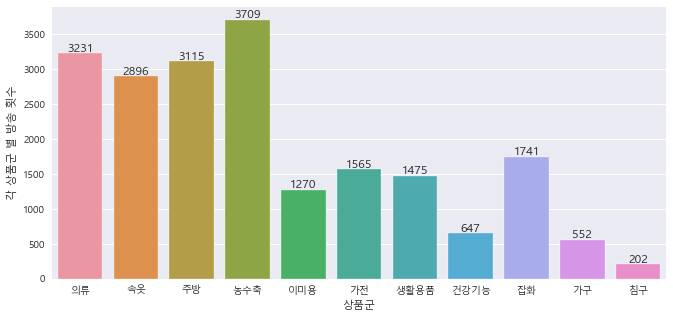

In [25]:
plt.figure(figsize = (11, 5))
plot = sns.countplot(x = 'group', data = sales3)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.xlabel("상품군")
plt.ylabel("각 상품군 별 방송 횟수")

* ns = 농수산 이기 때문에 농수축이 역시나 제일 많고 
* 의외로 의류/속옷, 주방 제품 방송 횟수가 많음 

In [28]:
sales3['date'] = pd.to_datetime(sales3['date'])

C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
sales3['방송일'] = sales3['date'].dt.date
sales3['방송시간(시)'] = sales3['date'].dt.hour
sales3['방송시간(분)'] = sales3['date'].dt.minute
sales3['방송요일'] = sales3['date'].dt.weekday

C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

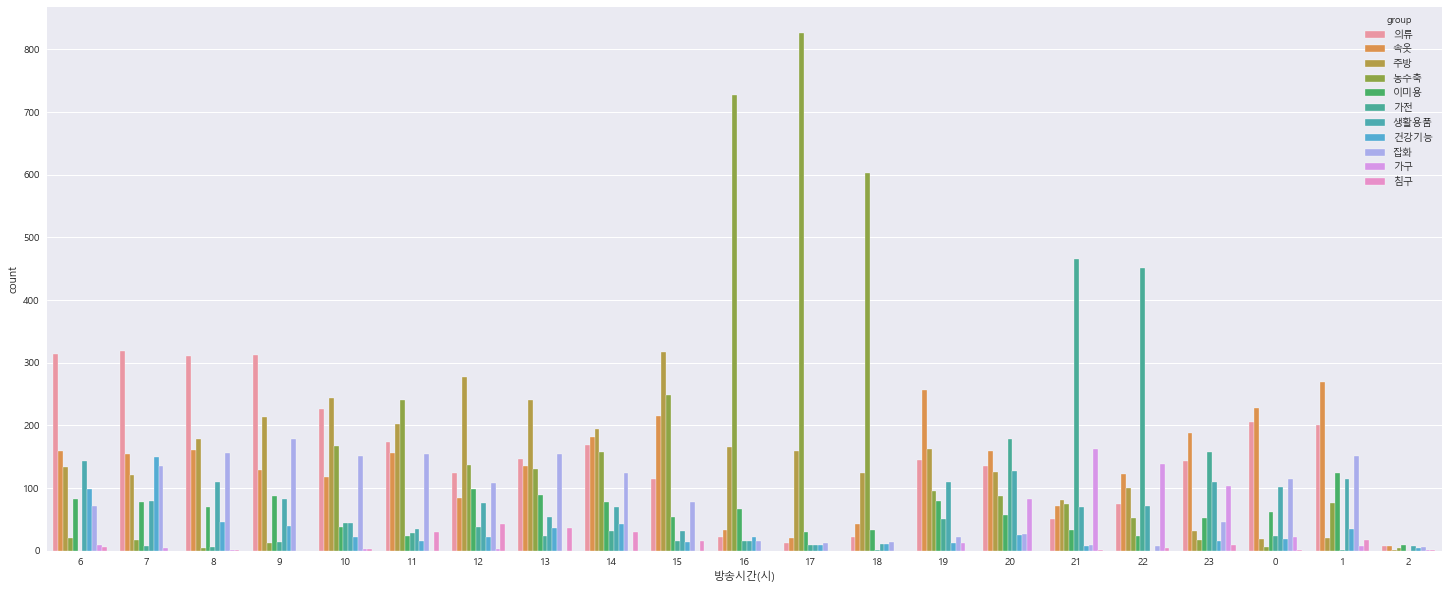

In [49]:
plt.figure(figsize = (25, 10))
sns.countplot(x="방송시간(시)", hue="group", data=sales3, 
             order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2])

* 확실히 카테고리마다 주요 편성 시간대가 다른 것을 볼 수 있다 ! 

In [38]:
group1 = sales3.query("group == '의류' or group=='속옷' or group=='잡화' or group=='이미용'")
group2 = sales3.query("group == '농수축' or group=='건강기능'")
group3 = sales3.query("group == '생활용품' or group=='가전' or group=='주방'")
group4 = sales3.query("group == '가구' or group=='침구'")

print(group1.shape, group2.shape, group3.shape, group4.shape)

(9138, 12) (4356, 12) (6155, 12) (754, 12)


* group1 - 의 : 의류 / 속옷 / 잡화 / 이미용 
* group2 - 식 : 농수축 / 건강기능 
* group3 - 생활용품 / 가전 / 주방 
* group4 - 가구 / 침구 

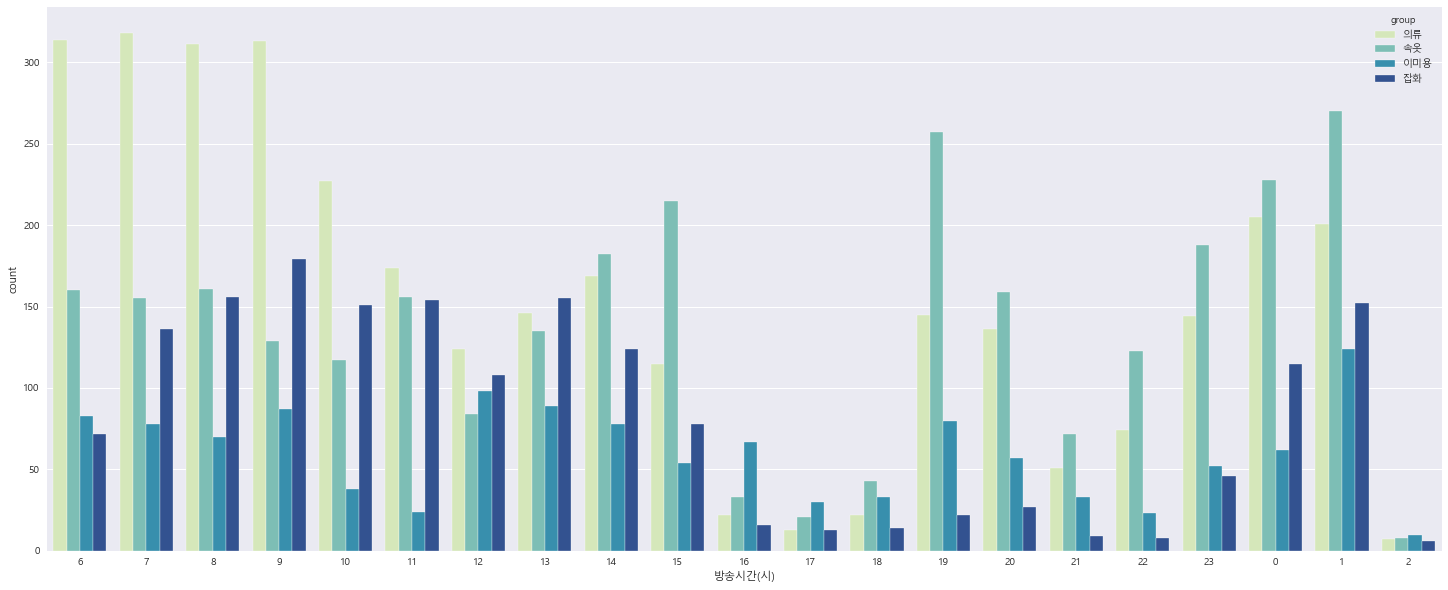

In [46]:
# group1 - 의 : 의류 / 속옷 / 잡화 / 이미용 
plt.figure(figsize = (25, 10))
sns.countplot(x="방송시간(시)", hue="group", data=group1, palette="YlGnBu",
             order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2])

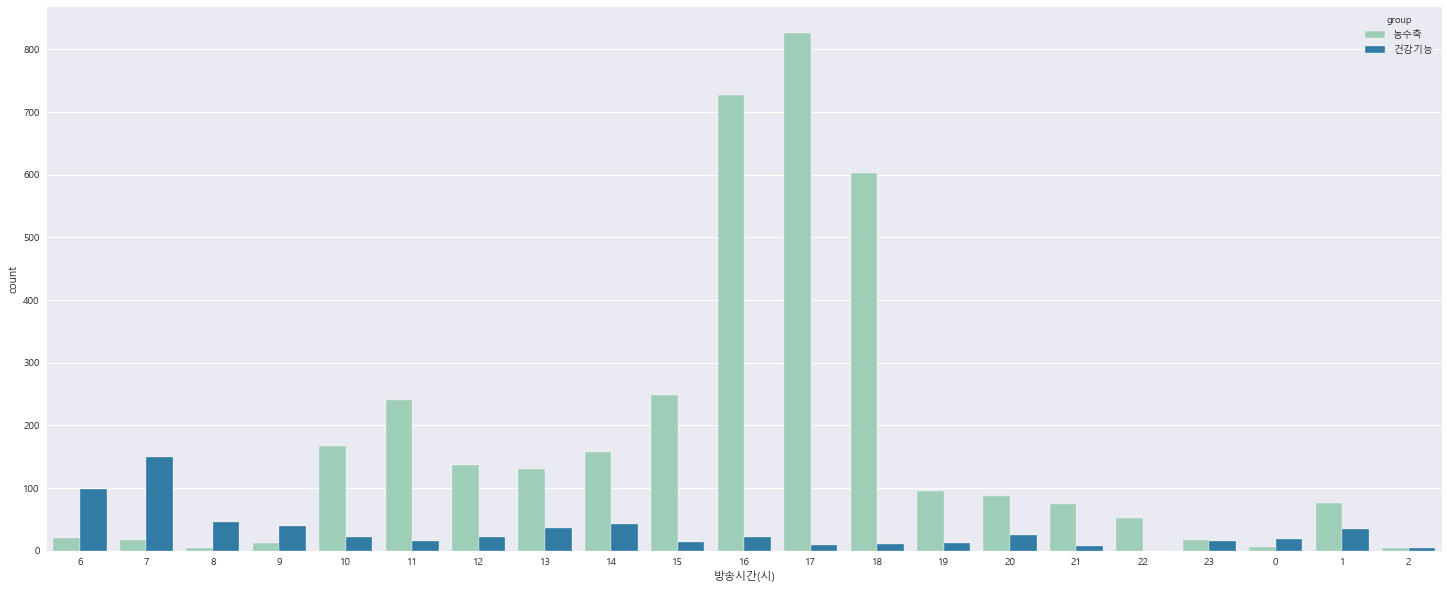

In [45]:
# group2 - 식 : 농수축 / 건강기능 
plt.figure(figsize = (25, 10))
sns.countplot(x="방송시간(시)", hue="group", data=group2, palette="YlGnBu",
             order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2])

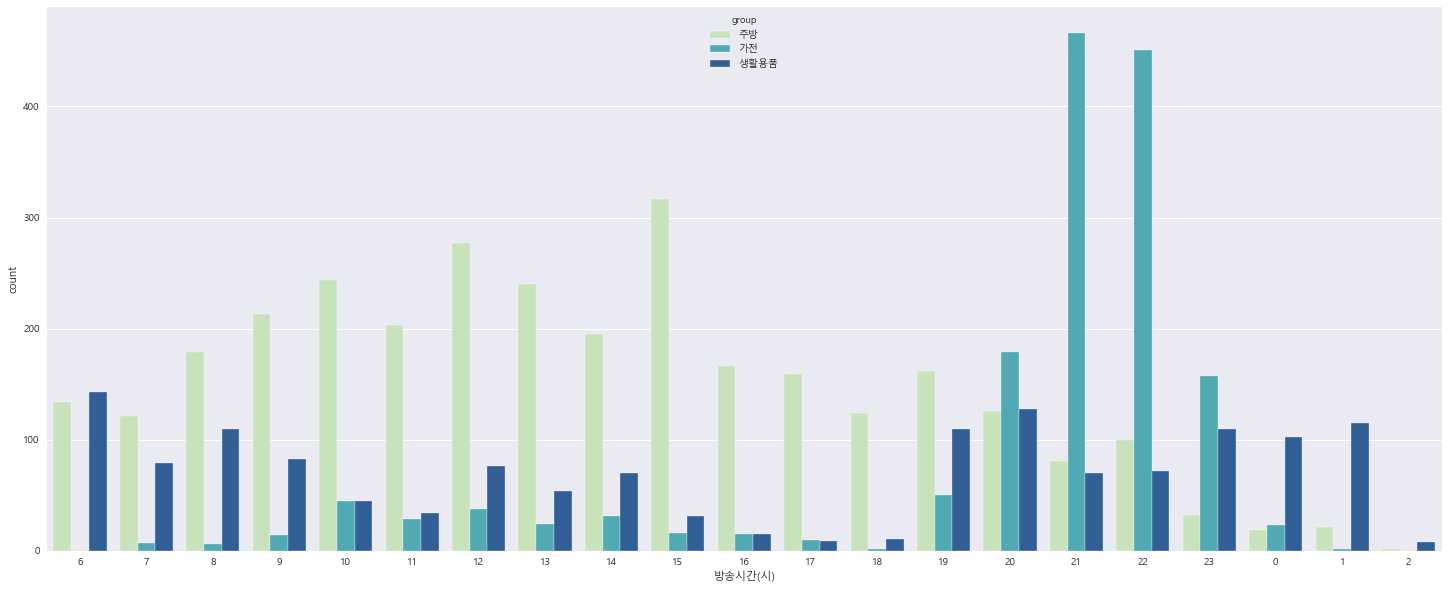

In [47]:
# group3 - 생활용품 / 가전 / 주방 
plt.figure(figsize = (25, 10))
sns.countplot(x="방송시간(시)", hue="group", data=group3, palette="YlGnBu",
             order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2])

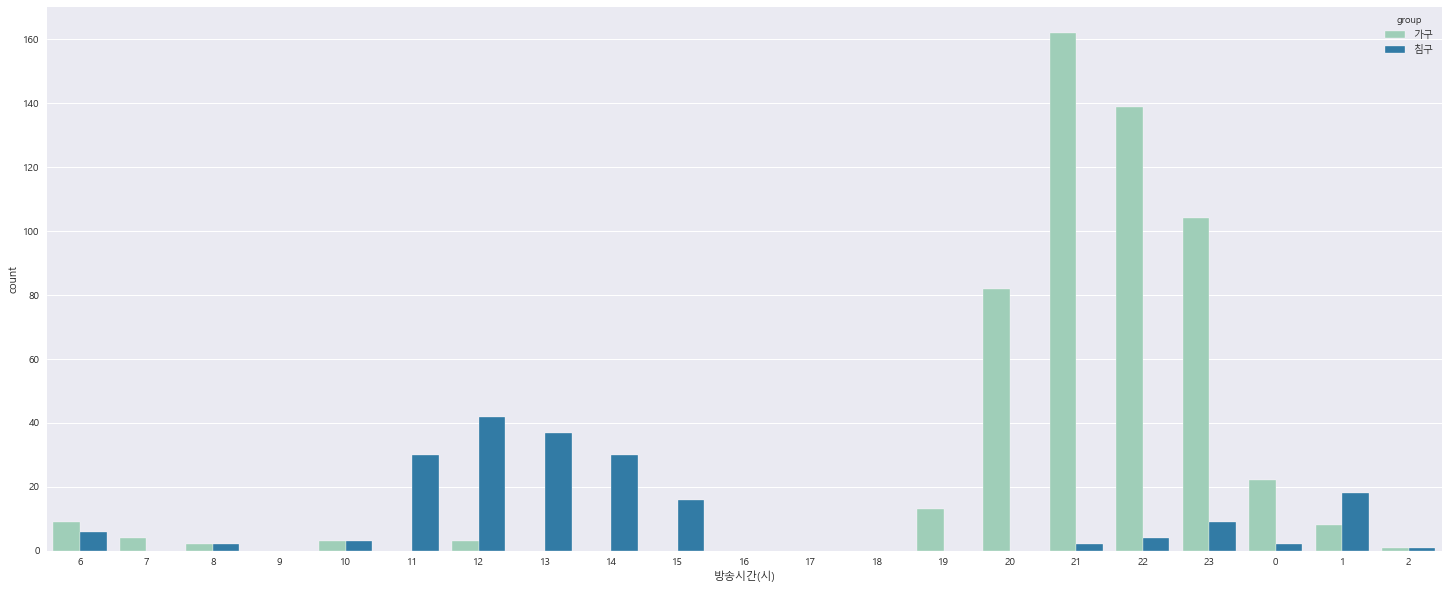

In [48]:
# group4 - 가구 / 침구
plt.figure(figsize = (25, 10))
sns.countplot(x="방송시간(시)", hue="group", data=group4, palette="YlGnBu",
             order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2])

* 의류 : 아침 (6시-9시)
* 농수축 : 오후 (16시 - 18시) 
* 가전 : 저녁 (20시 - 22시) 
* 가구 : 저녁 (21시 - 23시) 

In [53]:
# 그럼 이 편성표가 진짜로 유의미할까...? 
# 취급액, 판매단가와 비교해 보자 

sales['date'] = pd.to_datetime(sales['date'])

sales['방송일'] = sales['date'].dt.date
sales['방송시간(시)'] = sales['date'].dt.hour
sales['방송시간(분)'] = sales['date'].dt.minute
sales['방송요일'] = sales['date'].dt.weekday

In [54]:
group11 = sales.query("group == '의류' or group=='속옷' or group=='잡화' or group=='이미용'")
group21 = sales.query("group == '농수축' or group=='건강기능'")
group31 = sales.query("group == '생활용품' or group=='가전' or group=='주방'")
group41 = sales.query("group == '가구' or group=='침구'")

print(group11.shape, group21.shape, group31.shape, group41.shape)

(13240, 12) (4670, 12) (14503, 12) (2966, 12)


#### 취급액(total) 및 판매 단가(mean, median)와 비교 

In [69]:
order = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2]

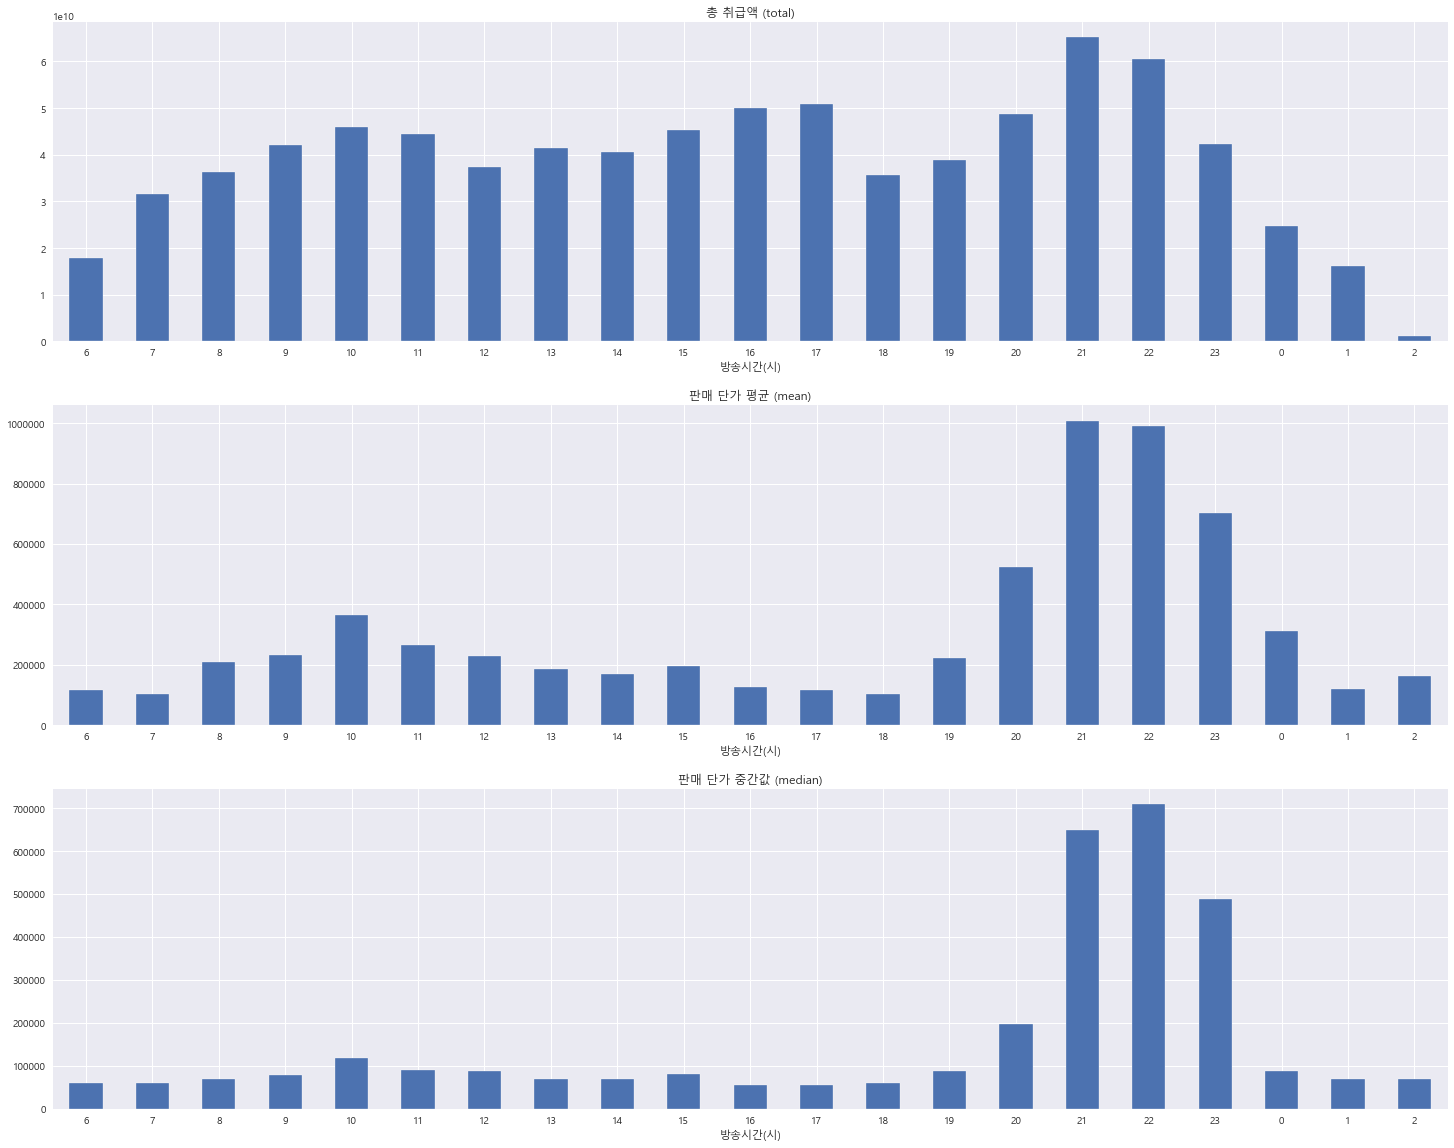

In [102]:
# 전체 추세 
f, ax = plt.subplots(3, 1, figsize=(25,20))
sales.groupby('방송시간(시)').total.sum().loc[order].plot.bar(rot = 0, ax = ax[0])
sales.groupby('방송시간(시)').price.mean().loc[order].plot.bar(rot = 0, ax = ax[1])
sales.groupby('방송시간(시)').price.median().loc[order].plot.bar(rot = 0, ax = ax[2])

ax[0].set_title('총 취급액 (total)')
ax[1].set_title('판매 단가 평균 (mean)')
ax[2].set_title('판매 단가 중간값 (median)')

plt.show()

* 전체 그룹을 한 번에 묶어서 봤을 때에는 21시 ~ 23시에 높은 가격대의 상품을 편성한 것을 볼 수 있음 
* 오전 시간대에는 판매 단가 자체는 낮은 값으로 구성하지만, 총 취급액은 꽤 높음 

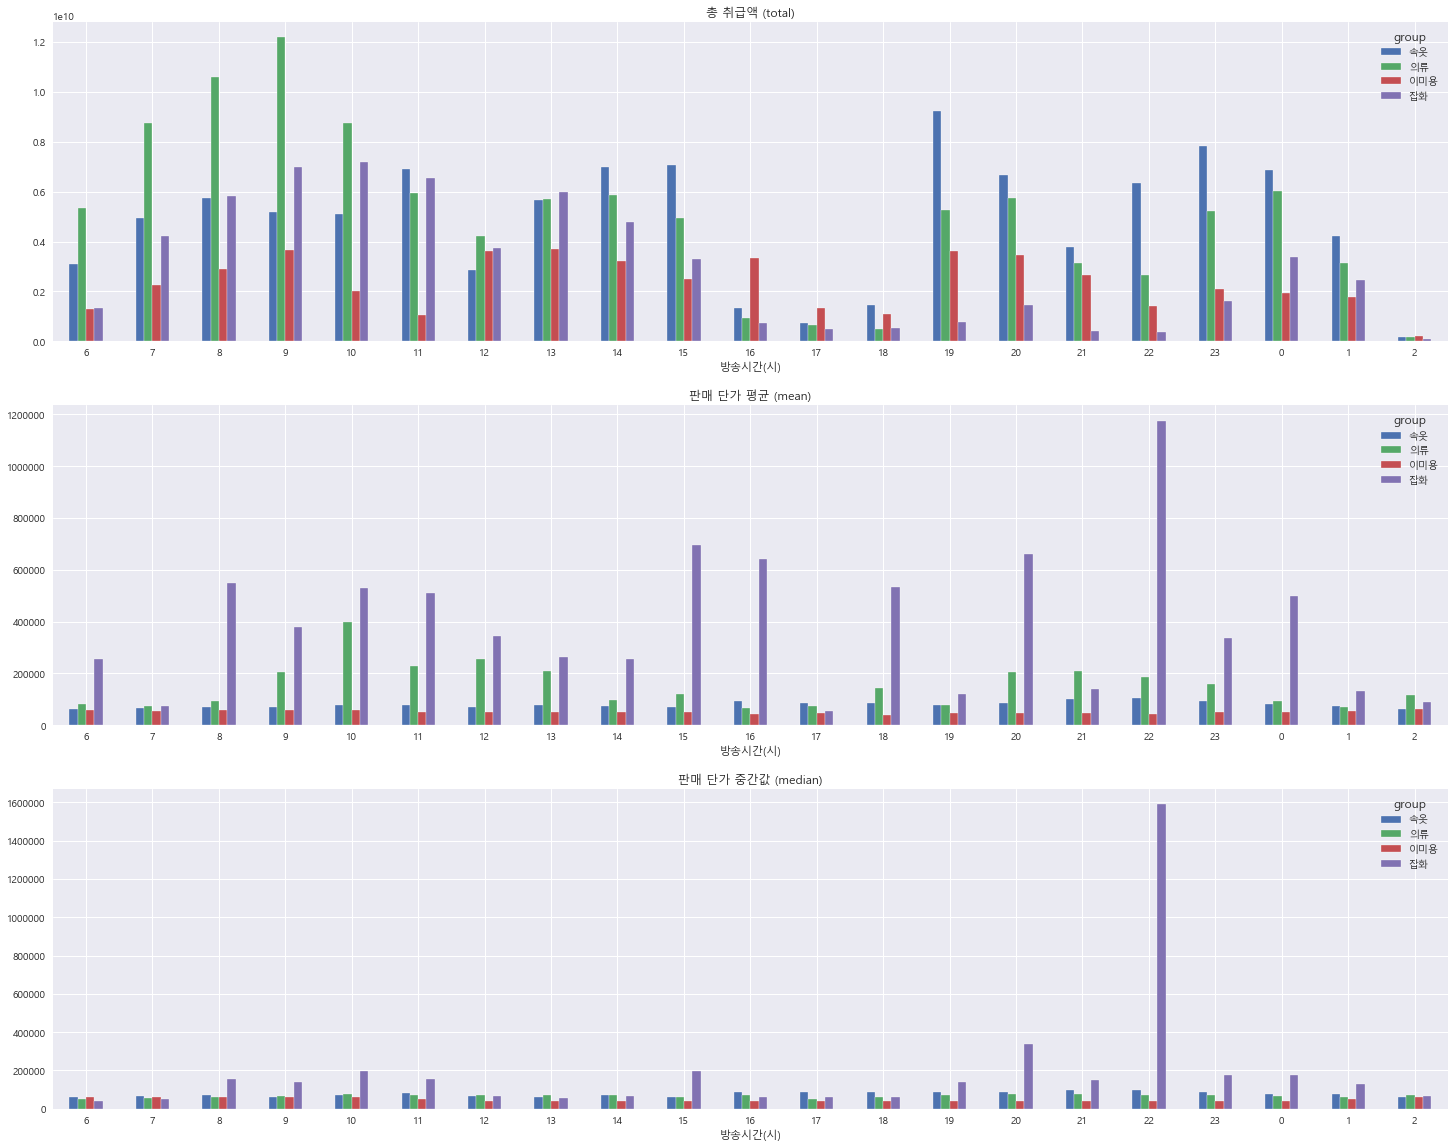

In [103]:
# group1 - 의 : 의류 / 속옷 / 잡화 / 이미용 
f, ax = plt.subplots(3, 1, figsize=(25,20))
group11.groupby(['방송시간(시)', 'group']).total.sum().unstack().loc[order].plot.bar(rot = 0, ax = ax[0])
group11.groupby(['방송시간(시)', 'group']).price.mean().unstack().loc[order].plot.bar(rot = 0, ax = ax[1])
group11.groupby(['방송시간(시)', 'group']).price.median().unstack().loc[order].plot.bar(rot = 0, ax = ax[2])

ax[0].set_title('총 취급액 (total)')
ax[1].set_title('판매 단가 평균 (mean)')
ax[2].set_title('판매 단가 중간값 (median)')

plt.show()

* 가격대가 좀 나가는 잡화는 22시에 편성 

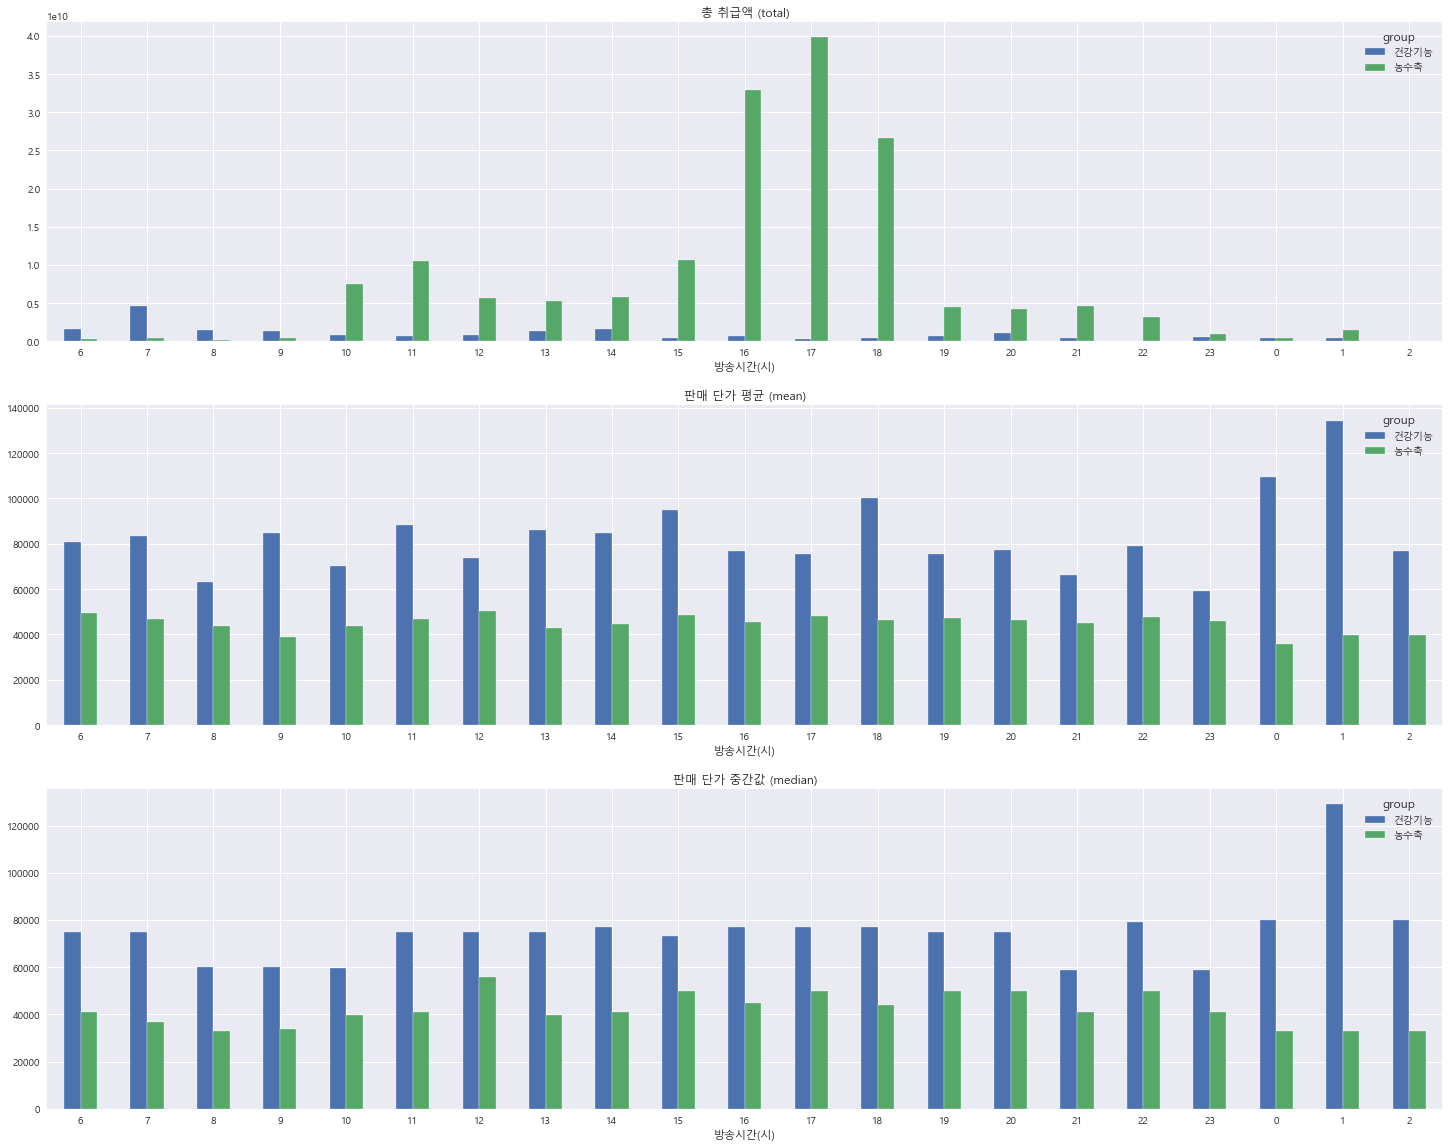

In [104]:
# group2 - 식 : 농수축 / 건강기능 
f, ax = plt.subplots(3, 1, figsize=(25,20))
group21.groupby(['방송시간(시)', 'group']).total.sum().unstack().loc[order].plot.bar(rot = 0, ax = ax[0])
group21.groupby(['방송시간(시)', 'group']).price.mean().unstack().loc[order].plot.bar(rot = 0, ax = ax[1])
group21.groupby(['방송시간(시)', 'group']).price.median().unstack().loc[order].plot.bar(rot = 0, ax = ax[2])

ax[0].set_title('총 취급액 (total)')
ax[1].set_title('판매 단가 평균 (mean)')
ax[2].set_title('판매 단가 중간값 (median)')

plt.show()

* 건강기능 / 농수축 카테고리는 대체로 다 가격대가 비슷함 ! 

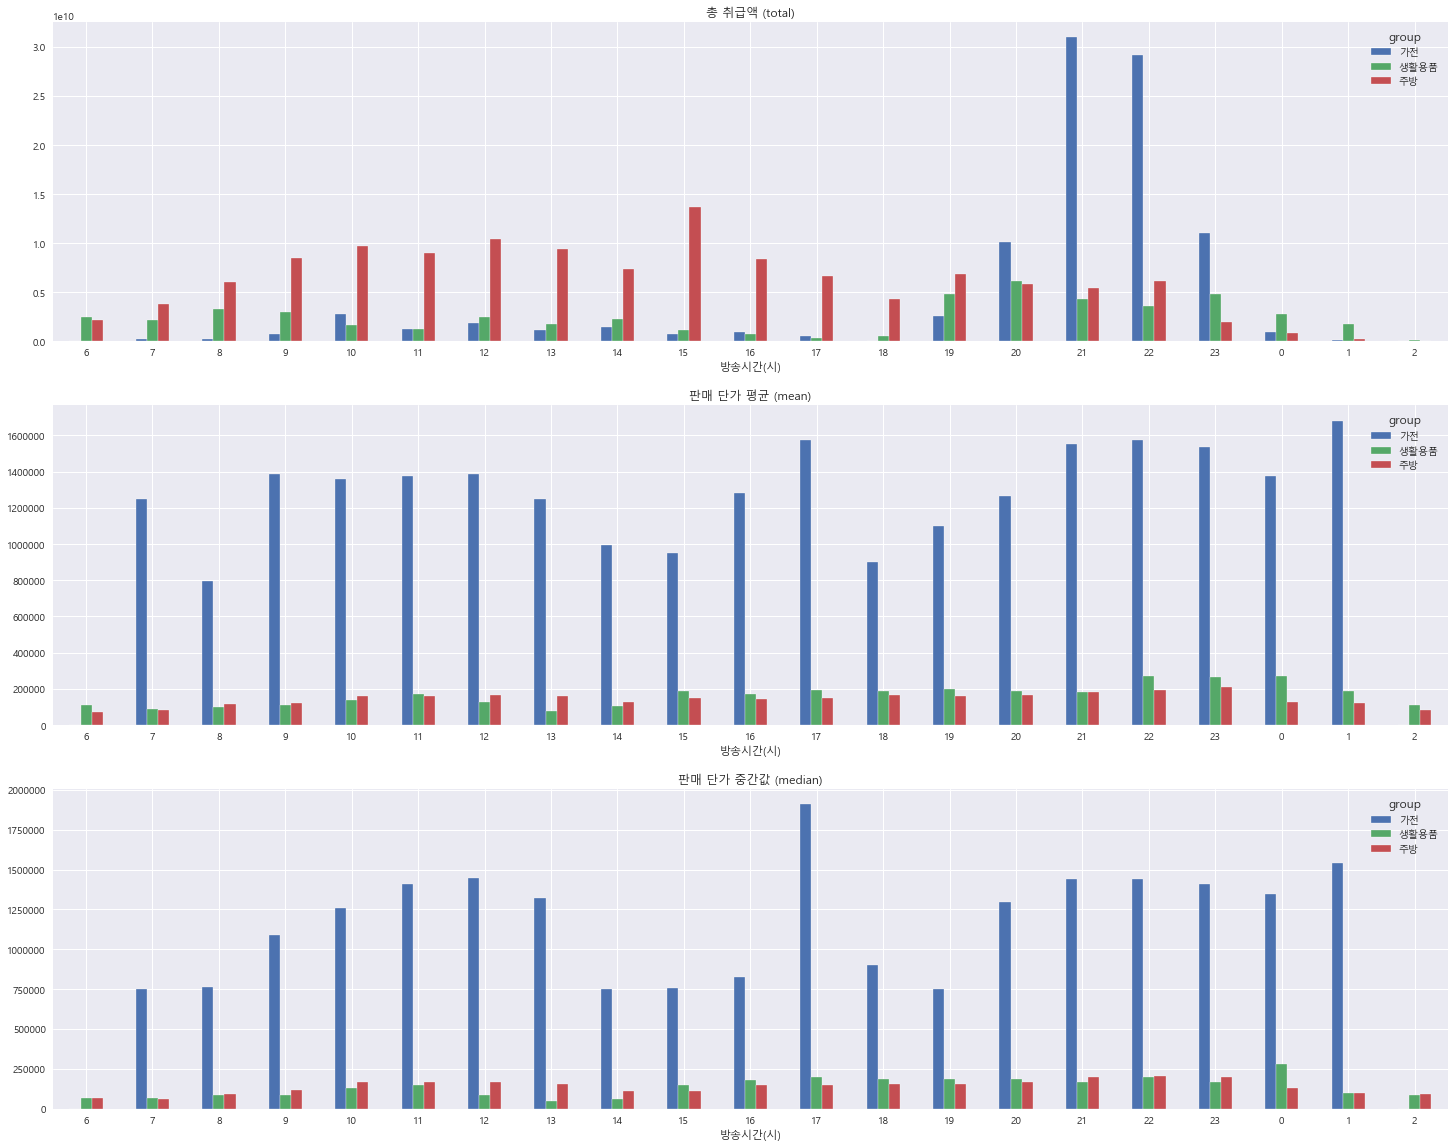

In [105]:
# group3 - 생활용품 / 가전 / 주방 
f, ax = plt.subplots(3, 1, figsize=(25,20))
group31.groupby(['방송시간(시)', 'group']).total.sum().unstack().loc[order].plot.bar(rot = 0, ax = ax[0])
group31.groupby(['방송시간(시)', 'group']).price.mean().unstack().loc[order].plot.bar(rot = 0, ax = ax[1])
group31.groupby(['방송시간(시)', 'group']).price.median().unstack().loc[order].plot.bar(rot = 0, ax = ax[2])

ax[0].set_title('총 취급액 (total)')
ax[1].set_title('판매 단가 평균 (mean)')
ax[2].set_title('판매 단가 중간값 (median)')

plt.show()

* 17시 즈음에 좀 높은 가격대의 상품을 편성하긴 하는데, 그 외에 특이한 형태를 보이지는 않는 것 같음 
* (가전) 21시 즈음에 총 취급액이 높은데, 이는 그 시간대에 가전제품 방송을 많이 편성해서 그런 것 같음      
* 비싼 가격대의 상품은 오히려 17시즈음에 편성하는데, 17시에서의 가전제품 편성 횟수는 적음...!! 그래서 총 취급액도 매우 적음 

C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\Users\LG\venv\jbeen\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .re

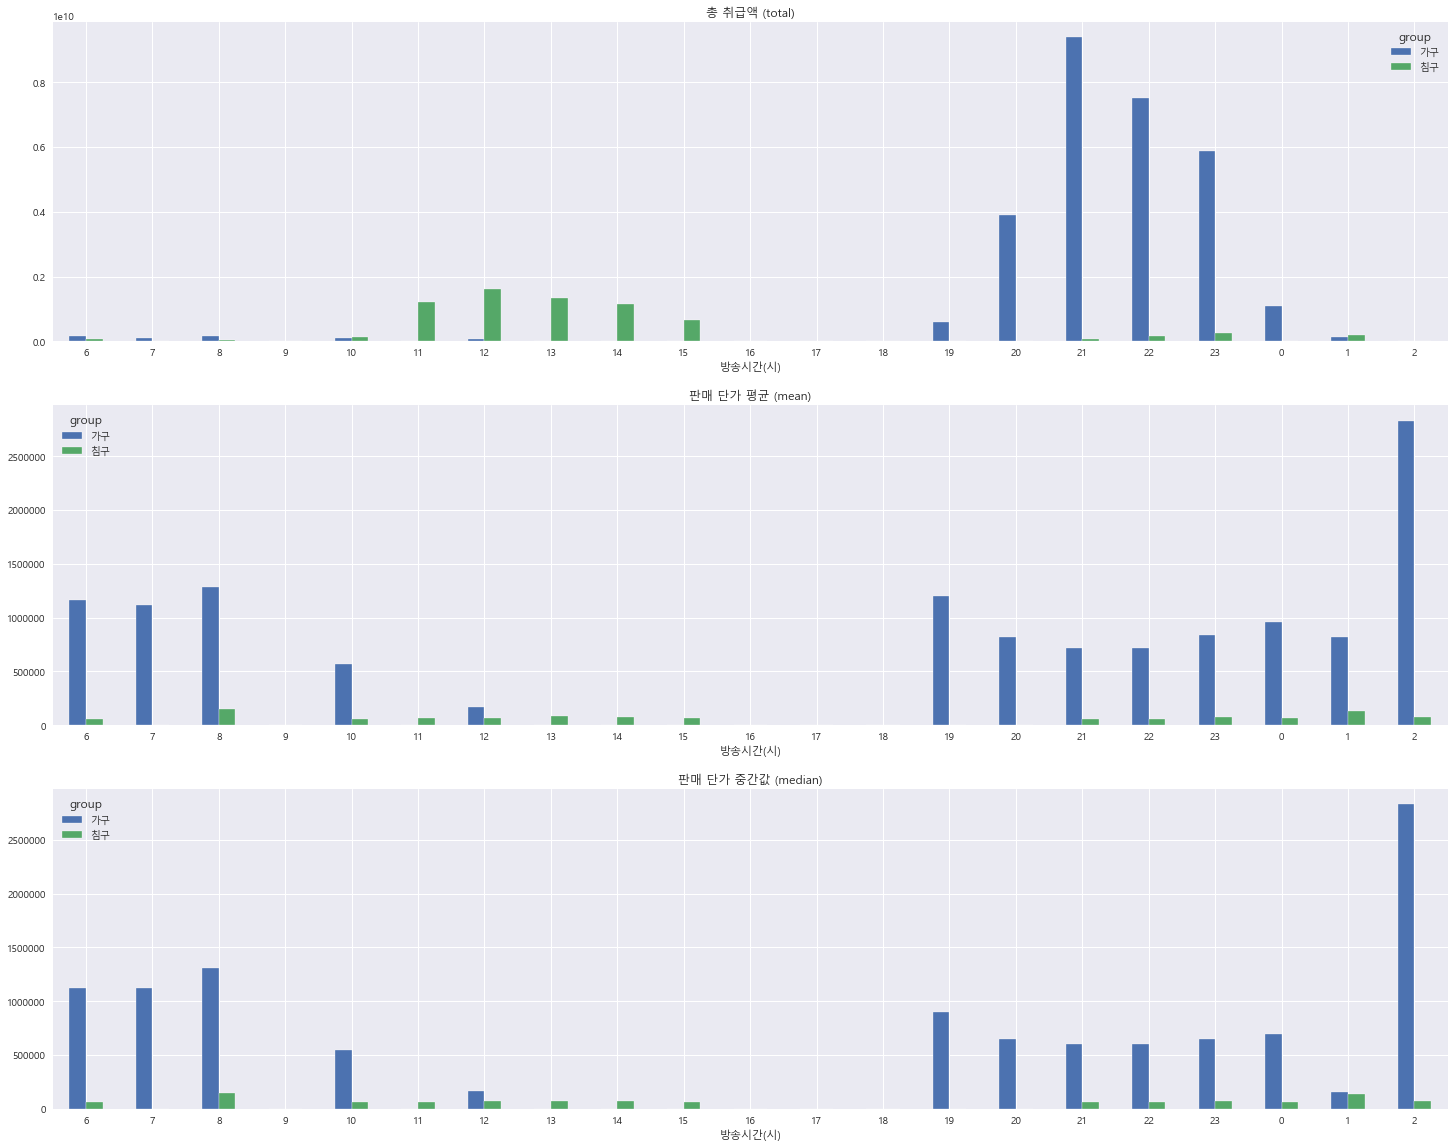

In [106]:
# group4 - 가구 / 침구
f, ax = plt.subplots(3, 1, figsize=(25,20))
group41.groupby(['방송시간(시)', 'group']).total.sum().unstack().loc[order].plot.bar(rot = 0, ax = ax[0])
group41.groupby(['방송시간(시)', 'group']).price.mean().unstack().loc[order].plot.bar(rot = 0, ax = ax[1])
group41.groupby(['방송시간(시)', 'group']).price.median().unstack().loc[order].plot.bar(rot = 0, ax = ax[2])

ax[0].set_title('총 취급액 (total)')
ax[1].set_title('판매 단가 평균 (mean)')
ax[2].set_title('판매 단가 중간값 (median)')

plt.show()

* 2시에 비싼 가격의 가구를 많이 팔긴 하는데.. 2시 데이터는 유의미한가...?? (11월 1일 이후 2시 ~ 2:20 데이터라면 가능..)

< 결론 > 
* 11가지 카테고리 모두 편성 횟수와 총 취급액의 추세가 완전 동일한 형태를 보임 ( = 편성 횟수가 많아지면 총 취급액이 커진다 ) 
* 편성을 그렇게 했기 때문에 많이 팔아서 당연하게 동일한 형태를 보이는 건가 ? 


* 많이 방송하는 시간에 비싼 제품을 팔거나, 적게 방송하는 시간에 저렴한 상품을 팔거나 하지는 않았던 것으로 보임 
* but 의류 같은 경우는 대부분 가격대가 비슷비슷하므로 크게 상관이 없었을 것 같긴 함 

## 가격 

### 상품의 전반적인 가격대 

In [146]:
print(sales.shape)
sales.head()

(35379, 12)


,date,onair,mothercode,productcode,product,group,price,total,방송일,방송시간(시),방송시간(분),방송요일
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,2019-01-01,6,0,1
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,2019-01-01,6,0,1
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,2019-01-01,6,20,1
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,2019-01-01,6,20,1
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,2019-01-01,6,40,1


In [150]:
sales.groupby(["price"]).size()

price
12800        3
19900        6
24900        3
28900       17
29000      218
          ... 
3690000      6
3990000      3
4250000      1
5060000      4
7930000      1
Length: 388, dtype: int64

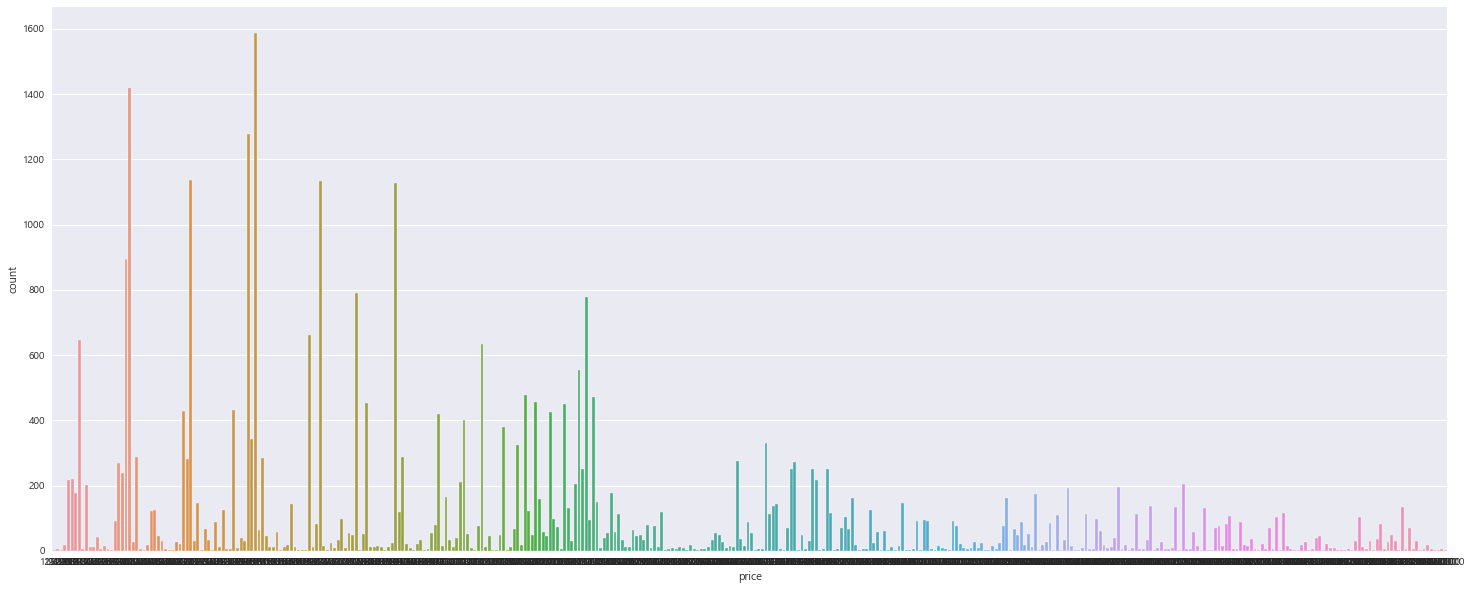

In [158]:
plt.figure(figsize = (25, 10))
sns.countplot(x="price", data=sales)

### 각 카테고리마다 저렴한 상품 + 가격대가 있는 상품 

In [171]:
def category_check(df, category) : 
    cheap = df.loc[df["group"] == category].sort_values("price",ascending=True).head(5)
    expensive = df.loc[df["group"] == category].sort_values("price",ascending=False).head(5)
    
    final = pd.concat([cheap, expensive])
    
    return final

In [173]:
for category in sales["group"].unique() : 
    print(category)
    print(category_check(sales, category))
    print(" ")

의류
                     date  onair  mothercode  productcode  \
18706 2019-06-26 09:00:00   20.0      100818       202412   
10112 2019-04-10 10:40:00   20.0      100783       202293   
22696 2019-08-02 07:00:00   20.0      100455       201402   
23787 2019-08-12 07:40:00   20.0      100456       201407   
15204 2019-05-23 10:40:00   20.0      100815       202411   
26558 2019-09-08 10:40:00   10.0      100352       201144   
24357 2019-08-17 09:20:00   10.0      100352       201144   
25188 2019-08-25 10:20:00   10.0      100352       201144   
25187 2019-08-25 10:10:00   10.0      100352       201144   
25186 2019-08-25 10:00:00   10.0      100352       201144   

                           product group    price     total         방송일  \
18706                   보코 에스닉 앙상블    의류    29000  28888000  2019-06-26   
10112                엔셀라두스 밴딩팬츠 3종    의류    29000  38324000  2019-04-10   
22696              NNF 쉬폰 썸머 앙상블세트    의류    29000  22274000  2019-08-02   
23787               NNF 와

### 각 카테고리마다 총 취급액이 낮은 + 높은 상품 

In [176]:
def category_total_check(df, category) : 
    cheap = df.loc[df["group"] == category].sort_values("total",ascending=True).head(5)
    expensive = df.loc[df["group"] == category].sort_values("total",ascending=False).head(5)
    
    final = pd.concat([cheap, expensive])
    
    return final

In [177]:
for category in sales["group"].unique() : 
    print(category)
    print(category_total_check(sales, category))
    print(" ")
    print(" ")

의류
                     date  onair  mothercode  productcode  \
10210 2019-04-11 01:00:00    NaN      100464       201431   
14613 2019-05-18 06:00:00    NaN      100374       201205   
31382 2019-10-23 09:00:00    NaN      100128       200348   
31381 2019-10-23 09:00:00   10.0      100128       200338   
28817 2019-09-29 10:00:00   10.0      100128       200337   
35784 2019-12-07 01:40:00   17.0      100418       201322   
37356 2019-12-21 17:40:00   20.0      100418       201322   
36267 2019-12-11 00:00:00   20.0      100418       201322   
20498 2019-07-13 10:30:00   30.0      100352       201125   
32805 2019-11-07 00:00:00   20.0      100340       201057   

                            product group    price      total         방송일  \
10210               디키즈 아동 스테디움점퍼세트    의류    54000     220000  2019-04-11   
14613        USPA  여성 아동 반팔 폴로셔츠 3종    의류    69000     268000  2019-05-18   
31382            뱅뱅 여성 구스다운 2종(ARS)    의류    89000     310000  2019-10-23   
31381            

# 시청률 
* 시청률 데이터는 어떻게 엮으면 좋을 것인지 고민을 많이 해 봐야 할 것 같음 (버리기에는 준 이유가 있을 것 같은데 ㅜㅜ) 
* 시청률과 총 취급액의 관계가 실제로 유의미한지 체크해 봐야 할 것 같음 